<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numerical integration of SDEs

### Exercise 1
Implement numerical integration of the cev model.

In [ ]:
import numpy as np
import numpy.typing as npt
import scipy.stats as stats
from scipy.optimize import brentq
import pandas as pd


def cev_model_mc(
    s0: float,
    t: float,
    vol: float,
    gamma: float,
    mu: float,
    n_paths: int,
    n_steps: int,
    use_millstein_scheme: bool = False
) -> npt.NDArray[np.float64]:
    """Returns array of shape (n_paths, n_steps) containing paths of the Cev model."""
    dt = t / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = s0

    for i in range(n_steps):
        s = paths[:, i]
        s = np.clip(s, 0, 1e3)
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        diffusion = vol * np.power(np.maximum(s, 0), gamma)

        if use_millstein_scheme:
            derivative = vol * gamma * np.power(np.maximum(s, 0), gamma - 1)
            paths[:, i + 1] = s + mu * s * dt + diffusion * dW + 0.5 * diffusion * derivative * (dW**2 - dt)
        else:
            paths[:, i + 1] = np.clip(s + mu * s * dt + diffusion * dW, 0, 1e3)

    return paths

### Exercise 2

For the MC scheme results, calculate mean and the confidence interval at specified level, using the unbiased variance estimator and assuming that we can use CLT approximation.

In [ ]:
def mc_mean_confidence_interval(mc_results: list[float], confidence_level=0.95) -> tuple[float, tuple[float, float]]:
    """Returns mean and confidence interval at specified level."""
    data = np.array(mc_results)
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    z = stats.norm.ppf(0.5 + confidence_level / 2)

    margin = z * std_err
    conf_interval = (mean - margin, mean + margin)

    return mean, conf_interval

### Exercise 3

Use hte results of exercise 1 and 2 to calculate the price and delta of the European call option in the CEV model.

Calculate the price of the following contract.
- s0 = 100.0
- t = 3.0
- vol = 0.3
- gamma = 1.5
- mu = 0.2
- strike in [70, 80, 90, 100]
- moneyness (K/s0) in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

Tweak the simulation parameters s.t. the price conf. interval at level 99% has width of at most 1 basis point for every strike.

Find the implied volatilities of these options and calculate the delta in the BS model using the results of Lab5.

In [ ]:
def bs_call_price(s0, k, t, r, sigma):
    if t <= 0 or sigma <= 0:
        return max(s0 - k, 0.0)
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return s0 * norm.cdf(d1) - k * np.exp(-r * t) * norm.cdf(d2)

def bs_delta(s0, k, t, r, sigma):
    if sigma <= 0:
        return 1.0 if s0 > k else 0.0
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    return norm.cdf(d1)

def implied_volatility_delta(price, s0, t, r, strike):
    intrinsic = max(s0 - strike, 0)
    max_price = s0

    if price < 1e-4:
        return 0.0001, 0.0

    def objective(sigma):
        return bs_call_price(s0, strike, t, r, sigma) - price

    try:
        iv = brentq(objective, 1e-6, 3.0)
        delta = bs_delta(s0, strike, t, r, iv)
    except Exception:
        iv = 0.0001
        delta = 1.0 if strike < s0 else 0.0

    return iv, delta


def european_call_cev_price(
    s0: float,
    t: float,
    vol: float,
    gamma: float,
    r: float,
    strike: float,
    n_paths: int,
    n_steps: int,
    confidence_level: float = 0.99,
    use_millstein_scheme: bool = False
) -> tuple[float, tuple[float, float]]:
    paths = cev_model_mc(
        s0=s0, t=t, vol=vol, gamma=gamma, mu=r,
        n_paths=n_paths, n_steps=n_steps,
        use_millstein_scheme=use_millstein_scheme
    )
    payoffs = np.maximum(paths[:, -1] - strike, 0)
    discounted_payoffs = np.exp(-r * t) * payoffs
    return mc_mean_confidence_interval(discounted_payoffs.tolist(), confidence_level)


def evaluate_options(
    s0=100.0,
    t=3.0,
    vol=0.3,
    gamma=1.5,
    r=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    n_steps=100,
    max_paths=200000,
    max_width=0.00015,
    price_clip=1e4
):
    results = []
    for strike in strikes:
        n_paths = 50000
        width = float("inf")
        mean, ci = float("nan"), (float("nan"), float("nan"))

        while width > max_width and n_paths <= max_paths:
            try:
                paths = cev_model_mc(s0, t, vol, gamma, r, n_paths, n_steps)
                final_prices = np.clip(paths[:, -1], 0, price_clip)
                payoffs = np.maximum(final_prices - strike, 0)
                discounted = np.exp(-r * t) * payoffs

                if np.any(np.isnan(discounted)) or np.any(np.isinf(discounted)):
                    raise ValueError("Numerical instability in discounted payoffs")

                mean, ci = mc_mean_confidence_interval(discounted.tolist(), confidence_level)
                width = ci[1] - ci[0]

                if width > max_width:
                    n_paths = int(n_paths * 2)

            except (MemoryError, ValueError):
                break

        iv, delta = implied_volatility_delta(mean, s0, t, r, strike)
        results.append((strike, mean, ci, iv, delta))

    df = pd.DataFrame(results, columns=["Strike", "CEV Price", "Confidence Interval", "Implied Vol", "Delta"])
    return df

df = evaluate_options()
print(df)

df2 = evaluate_options(s0=100.0,
    t=3.0,
    vol=0.3,
    gamma=1.1,
    r=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    n_steps=100,
    max_paths=200000,
    max_width=0.00015,
    price_clip=1e4
)
print(df2)


   Strike  CEV Price                         Confidence Interval  Implied Vol  \
0      70   0.188825  (0.15023302230345043, 0.22741715354290476)       0.0001   
1      80   0.206720   (0.16340445932926317, 0.2500345852590547)       0.0001   
2      90   0.165786  (0.12739333078567683, 0.20417898771872606)       0.0001   
3     100   0.169129  (0.12763363594334337, 0.21062368925801117)       0.0001   

   Delta  
0    1.0  
1    1.0  
2    1.0  
3    0.0  
   Strike  CEV Price                       Confidence Interval  Implied Vol  \
0      70  60.781120    (60.287483036946526, 61.2747570097208)     0.000100   
1      80  57.298487  (56.804441459664766, 57.792532321475456)     0.328025   
2      90  53.333061   (52.849104718013635, 53.81701817013334)     0.359559   
3     100  49.790026    (49.31315052941518, 50.26690129865868)     0.381073   

      Delta  
0  1.000000  
1  0.958441  
2  0.925630  
3  0.892338  


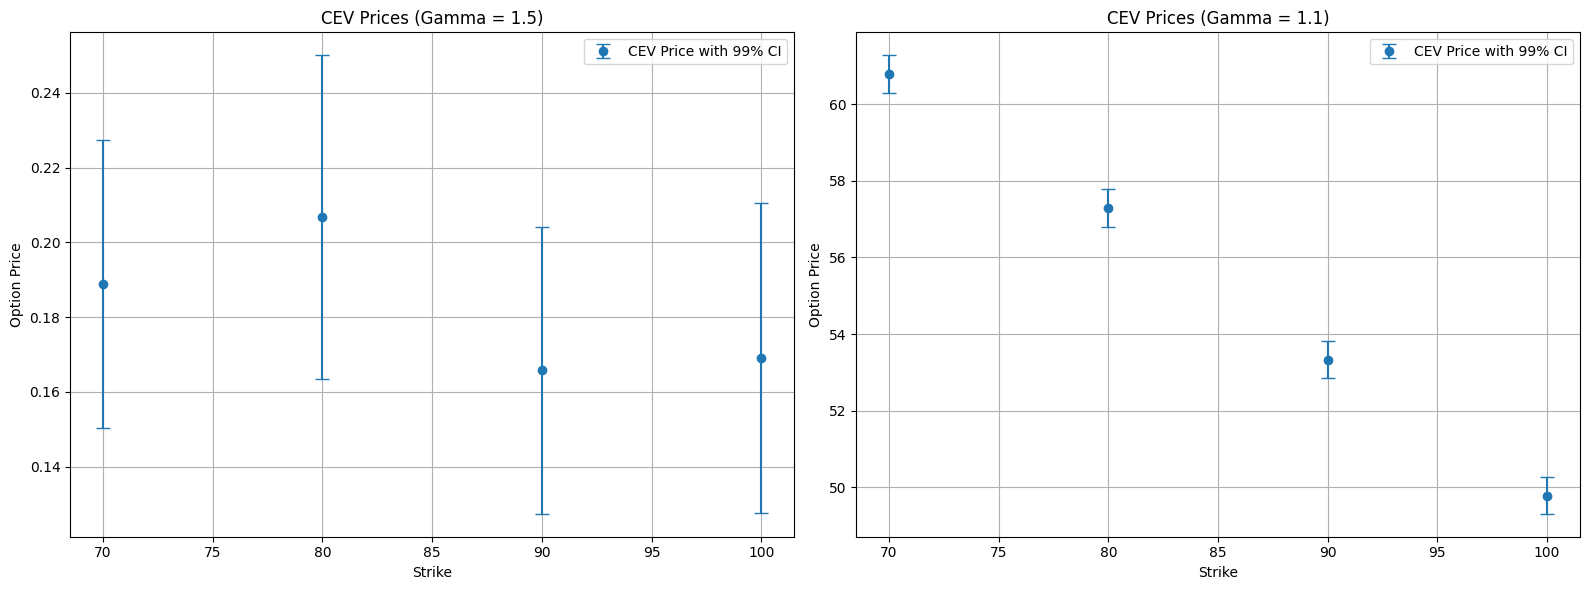

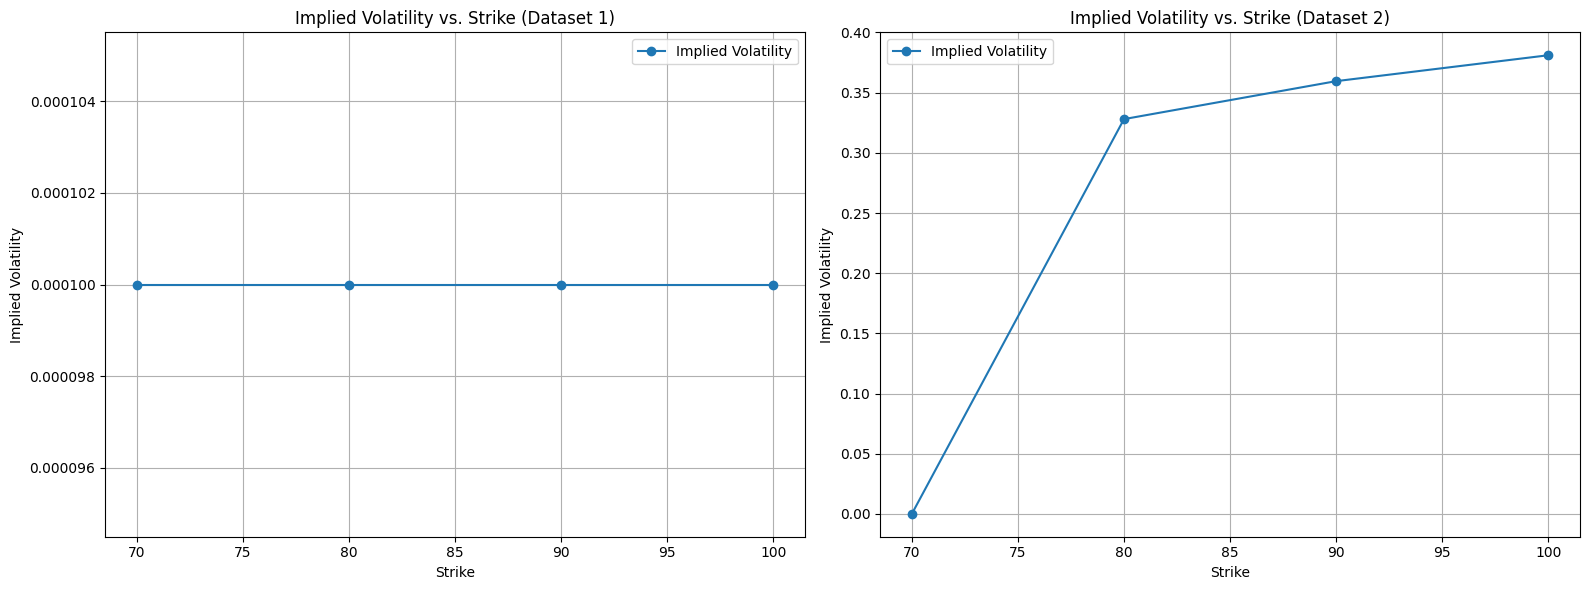

In [ ]:
import matplotlib.pyplot as plt

df_valid = df.dropna(subset=["CEV Price"])
df_valid2 = df2.dropna(subset=["CEV Price"])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].errorbar(
    df_valid["Strike"],
    df_valid["CEV Price"],
    yerr=[
        df_valid["CEV Price"] - df_valid["Confidence Interval"].apply(lambda x: x[0]),
        df_valid["Confidence Interval"].apply(lambda x: x[1]) - df_valid["CEV Price"]
    ],
    fmt='o',
    capsize=5,
    label="CEV Price with 99% CI"
)
axs[0].set_title("CEV Prices (Gamma = 1.5)")
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Option Price")
axs[0].grid(True)
axs[0].legend()

axs[1].errorbar(
    df_valid2["Strike"],
    df_valid2["CEV Price"],
    yerr=[
        df_valid2["CEV Price"] - df_valid2["Confidence Interval"].apply(lambda x: x[0]),
        df_valid2["Confidence Interval"].apply(lambda x: x[1]) - df_valid2["CEV Price"]
    ],
    fmt='o',
    capsize=5,
    label="CEV Price with 99% CI"
)
axs[1].set_title("CEV Prices (Gamma = 1.1)")
axs[1].set_xlabel("Strike")
axs[1].set_ylabel("Option Price")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

if df["Implied Vol"].notna().sum() > 0 and df2["Implied Vol"].notna().sum() > 0:
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(df["Strike"], df["Implied Vol"], 'o-', label="Implied Volatility")
    axs[0].set_title("Implied Volatility vs. Strike (Dataset 1)")
    axs[0].set_xlabel("Strike")
    axs[0].set_ylabel("Implied Volatility")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(df2["Strike"], df2["Implied Vol"], 'o-', label="Implied Volatility")
    axs[1].set_title("Implied Volatility vs. Strike (Dataset 2)")
    axs[1].set_xlabel("Strike")
    axs[1].set_ylabel("Implied Volatility")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In order to archive even tighter confidence intervals, we can increase the number of paths (more paths → lower variance → tighter confidence interval).

In [ ]:
df3 = evaluate_options(s0=100.0,
    t=3.0,
    vol=0.3,
    gamma=1.1,
    r=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    n_steps=100,
    max_paths=500000,
    max_width=0.0001,
    price_clip=1e4
)
print(df3)

df4 = evaluate_options(s0=100.0,
    t=3.0,
    vol=0.2,
    gamma=1.1,
    r=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    n_steps=100,
    max_paths=500000,
    max_width=0.0001,
    price_clip=1e4
)
print(df4)

   Strike  CEV Price                       Confidence Interval  Implied Vol  \
0      70  61.004916  (60.655042402122056, 61.354790028706624)     0.000100   
1      80  57.052954  (56.705700885213965, 57.400207289461854)     0.311188   
2      90  53.008866   (52.668470588993536, 53.34926166688141)     0.345936   
3     100  49.790932   (49.45373918630035, 50.128125264160616)     0.381101   

      Delta  
0  1.000000  
1  0.963807  
2  0.930135  
3  0.892330  
   Strike  CEV Price                      Confidence Interval  Implied Vol  \
0      70  61.764163  (61.515507832263104, 62.01281895930719)     0.263466   
1      80  56.793639  (56.546692499683864, 57.04058521745335)     0.290803   
2      90  52.078966   (51.83494115306488, 52.32298999838212)     0.301957   
3     100  47.463309  (47.223440976300026, 47.70317755365794)     0.301136   

      Delta  
0  0.989953  
1  0.970358  
2  0.946320  
3  0.920898  
